1. Problem statement
* We are given SBI stock price from 01/2018 to 12/2022.
* The task is to predict the trend of the stock price for 01/2023.
* The goal is to predict the close price of the given date from test data

Import the required Libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

Configure GPU options

In [4]:
config = tf.compat.v1.ConfigProto()

In [5]:
config.gpu_options.allow_growth=True

In [6]:
sess = tf.compat.v1.Session(config=config)

Review the Data 

In [11]:
# Change OS directory
os.chdir(r'C:\cyrdocs\IITM-DS')

In [12]:
# Read the Data
stock_data = pd.read_csv("SBI_train.csv")
test_data = pd.read_csv("SBI_test.csv")

In [13]:
# Data Exploration
stock_data.head()

,Date,Open,High,Low,Close,Volume
0,Jan 12 2018,304.65,304.65,300.55,302.25,17590000
1,Jan 15 2018,303.95,305.25,301.55,302.60,18190000
2,Jan 16 2018,302.40,303.35,295.30,296.15,18040000
3,Jan 17 2018,296.00,308.40,292.60,307.10,26280000
4,Jan 18 2018,315.00,317.80,300.50,303.25,40000000


In [14]:
# Data Exploration
stock_data.tail()

,Date,Open,High,Low,Close,Volume
1225,Dec 26 2022,574.00,601.70,570.70,597.10,13200000
1226,Dec 27 2022,600.40,603.10,593.30,601.90,9640000
1227,Dec 28 2022,600.90,607.00,598.55,601.05,7990000
1228,Dec 29 2022,600.00,618.00,597.15,611.80,20130000
1229,Dec 30 2022,615.25,620.55,611.35,613.70,13050000


In [15]:
# Data Exploration
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1230 non-null   object 
 1   Open    1230 non-null   float64
 2   High    1230 non-null   float64
 3   Low     1230 non-null   float64
 4   Close   1230 non-null   float64
 5   Volume  1230 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 57.8+ KB


From here we can see our data has 6 columns:

* Date: The date of recorded data
* Open: The price when stock market open
* High: The highest price price of date
* Low: The lowest price point of date
* Close: The price when stock market closed
* Volume: Total Sale of stock on that date

Data Processing

In [18]:
stock_data['Volume'] = stock_data['Volume'].apply(lambda x: float(str(x).replace(',','.')))

In [19]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1230 non-null   object 
 1   Open    1230 non-null   float64
 2   High    1230 non-null   float64
 3   Low     1230 non-null   float64
 4   Close   1230 non-null   float64
 5   Volume  1230 non-null   float64
dtypes: float64(5), object(1)
memory usage: 57.8+ KB


In [20]:
stock_data.sample(5)

,Date,Open,High,Low,Close,Volume
543,Mar 27 2020,202.00,211.90,195.0,195.95,114750000.0
214,Nov 28 2018,289.40,292.45,283.0,284.55,19840000.0
764,Feb 15 2021,397.50,409.45,395.7,406.95,56610000.0
117,Jul 04 2018,255.75,258.35,254.5,257.45,14210000.0
419,Sep 27 2019,282.70,286.05,280.0,281.20,37850000.0


Data Visualization

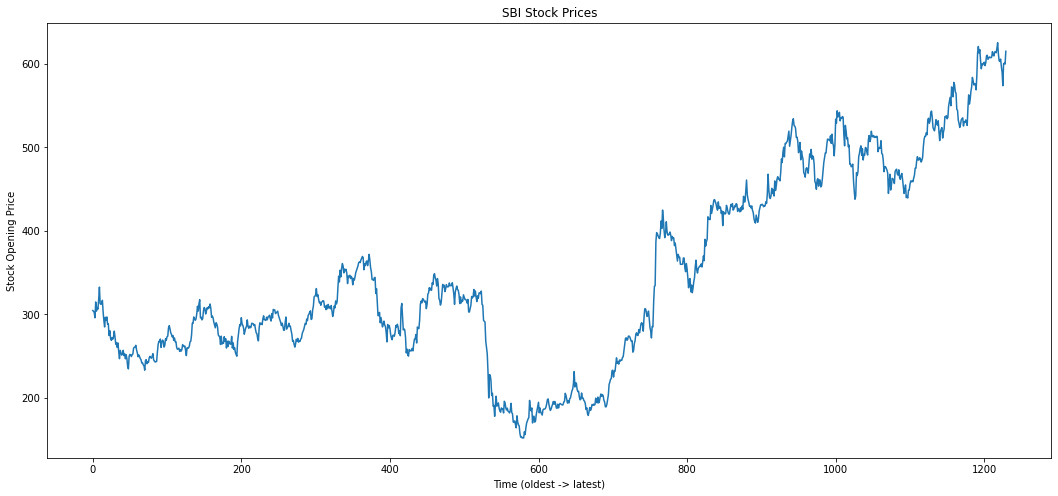

In [21]:
# Plot the Open price
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Open'])
plt.title("SBI Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Opening Price")
plt.show()

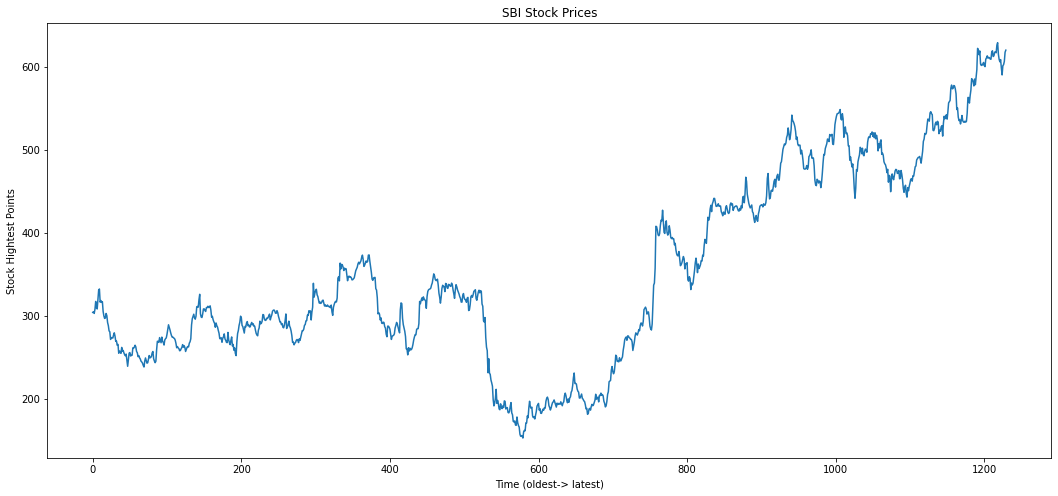

In [23]:
# Plot the High price
plt.figure(figsize=(18, 8))
plt.plot(stock_data['High'])
plt.title("SBI Stock Prices")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("Stock Hightest Points")
plt.show()

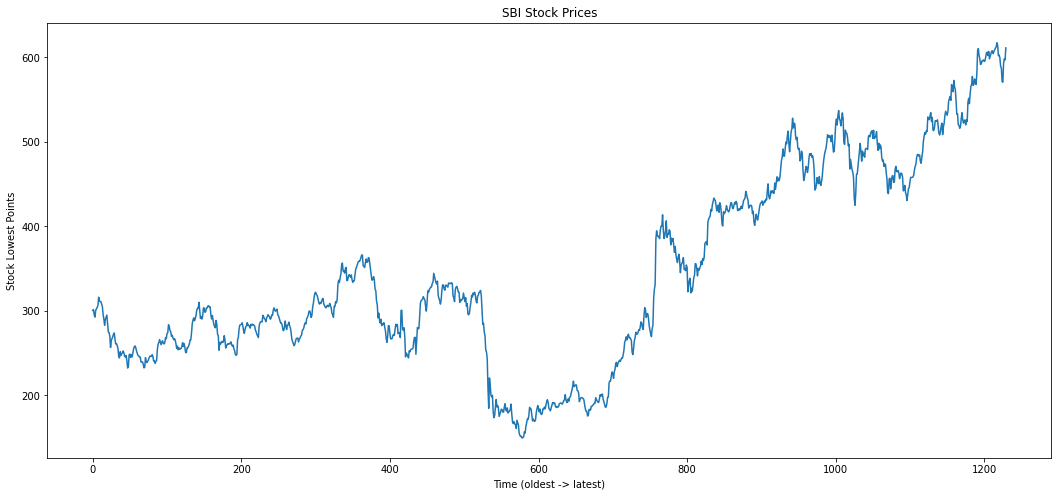

In [24]:
# Plot the Low price
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Low'])
plt.title("SBI Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Points")
plt.show()

Feature Selection
* Select Open, High, Low, Volume and Close columns with Close column as target

In [25]:
input_feature = stock_data[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values

In [26]:
input_data.shape

(1230, 5)

Data Normalization

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
input_data = scaler.fit_transform(input_data)

In [28]:
input_data

array([[0.32242399, 0.31793849, 0.32282876, 0.06746988, 0.31897187],
       [0.32094595, 0.31919807, 0.32496528, 0.07030475, 0.31970926],
       [0.31767314, 0.3152094 , 0.31161201, 0.06959603, 0.3061203 ],
       ...,
       [0.94795186, 0.95266086, 0.95951287, 0.02211198, 0.94848836],
       [0.94605152, 0.97575312, 0.95652174, 0.07947082, 0.97113663],
       [0.97825169, 0.98110633, 0.98686038, 0.04601937, 0.97513958]])

In [29]:
input_data.shape

(1230, 5)

Data Creation

In [30]:
lookback = 60
total_size = len(stock_data)

In [31]:
X=[]
y=[]
for i in range(0, total_size-lookback): # loop data set with margin 50 as we use 50 days data for prediction
    t=[]
    for j in range(0, lookback): # loop for 50 days
        current_index = i+j
        t.append(input_data[current_index, :]) # get data margin from 50 days with marging i
    X.append(t)
    y.append(input_data[lookback+i, 4])

In [32]:
len(X), len(y)

(1170, 1170)

Split the data and validate
* We will get last 120 days for testing (predict).
* 15% of the rest for validation
* 85% of the rest for training

In [33]:
X, y= np.array(X), np.array(y)
X.shape, y.shape

((1170, 60, 5), (1170,))

In [34]:
test_size = 120 

X_test = X[-test_size:]
Y_test = y[-test_size:]

X_rest = X[: -test_size]
y_rest = y[: -test_size]

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size = 0.15, random_state = 101)

Reshape the Data

In [35]:
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(892, 60, 5)
(158, 60, 5)
(120, 60, 5)


Model Creation

In [36]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [37]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [38]:
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [39]:
regressor.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.0011
Epoch 1: val_loss improved from inf to 0.00273, saving model to model.h5
112/112 [==============================] - 20s 114ms/step - loss: 0.0134 - accuracy: 0.0011 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.0011
Epoch 2: val_loss improved from 0.00273 to 0.00261, saving model to model.h5
112/112 [==============================] - 11s 102ms/step - loss: 0.0059 - accuracy: 0.0011 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.0011
Epoch 3: val_loss improved from 0.00261 to 0.00247, saving model to model.h5
112/112 [==============================] - 12s 104ms/step - loss: 0.0045 - accuracy: 0.0011 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
112/112 [========

Epoch 26/100
112/112 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.0011
Epoch 26: val_loss did not improve from 0.00083
112/112 [==============================] - 11s 102ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 8.4580e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 27/100
112/112 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.0011
Epoch 27: val_loss did not improve from 0.00083
112/112 [==============================] - 11s 102ms/step - loss: 0.0019 - accuracy: 0.0011 - val_loss: 8.3487e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 28/100
112/112 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.0011
Epoch 28: val_loss improved from 0.00083 to 0.00083, saving model to model.h5
112/112 [==============================] - 11s 102ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 8.2696e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 29/100
112/112 [==============================] -

112/112 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.0011
Epoch 52: val_loss did not improve from 0.00080
112/112 [==============================] - 12s 107ms/step - loss: 0.0016 - accuracy: 0.0011 - val_loss: 8.1367e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 53/100
112/112 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.0011
Epoch 53: val_loss did not improve from 0.00080
112/112 [==============================] - 12s 106ms/step - loss: 0.0017 - accuracy: 0.0011 - val_loss: 8.4864e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 54/100
112/112 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.0011
Epoch 54: val_loss did not improve from 0.00080
112/112 [==============================] - 12s 103ms/step - loss: 0.0017 - accuracy: 0.0011 - val_loss: 8.1154e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 55/100
112/112 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.0011


Epoch 79/100
112/112 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.0011
Epoch 79: val_loss improved from 0.00078 to 0.00078, saving model to model.h5
112/112 [==============================] - 12s 103ms/step - loss: 0.0016 - accuracy: 0.0011 - val_loss: 7.7580e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 80/100
112/112 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.0011
Epoch 80: val_loss did not improve from 0.00078
112/112 [==============================] - 11s 103ms/step - loss: 0.0015 - accuracy: 0.0011 - val_loss: 7.9815e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 81/100
112/112 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.0011
Epoch 81: val_loss did not improve from 0.00078
112/112 [==============================] - 12s 103ms/step - loss: 0.0016 - accuracy: 0.0011 - val_loss: 7.8080e-04 - val_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 82/100
112/112 [==============================] -

In [40]:
predicted_value = regressor.predict(X_test)

4/4 [==============================] - 1s 46ms/step


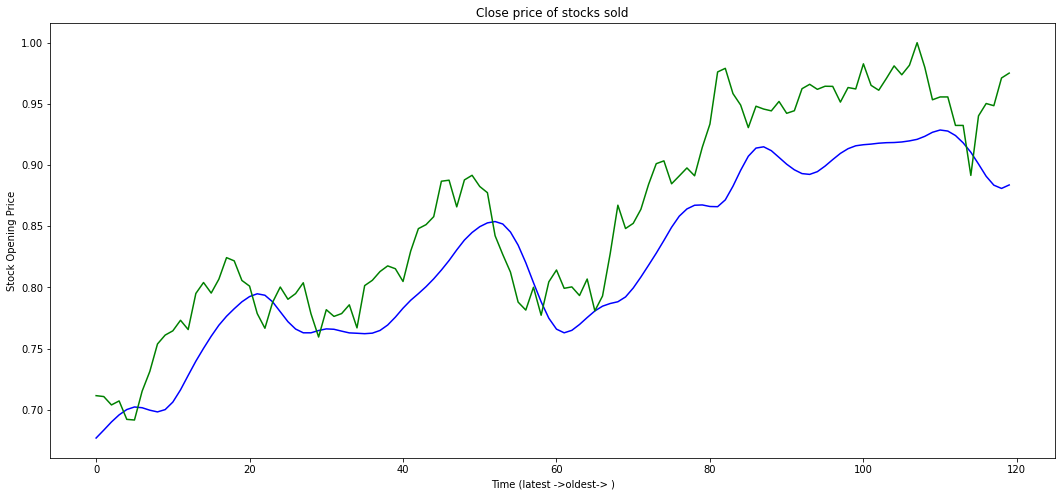

In [41]:
plt.figure(figsize=(18, 8))
plt.plot(predicted_value, color= 'blue')
plt.plot(Y_test, color='green')
plt.title("Close price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Opening Price")
plt.show()